<a href="https://colab.research.google.com/github/eschwarzbeckf/forecast_prices/blob/main/model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox as box

In [3]:
from sktime.forecasting.arima import StatsModelsARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.neuralforecast import NeuralForecastLSTM
from sktime.utils.plotting import plot_series, plot_correlations
from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.lag import Lag
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.compose import YtoX,Id
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import STLTransformer, Detrender, Deseasonalizer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.subset import ColumnSelect
from sktime.transformations.series.holiday import HolidayFeatures
from sktime.transformations.series.dummies import SeasonalDummiesOneHot
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from sktime.transformations.series.impute import Imputer

In [4]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/eschwarzbeckf/forecast_prices/refs/heads/main/csv/consolidated.csv',encoding='utf-8',parse_dates=True,index_col=0)
y = df['Sales']
x = df.drop(['Sales','Jalisco'],axis=1)

/tmp/ipython-input-2332179121.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index(pd.date_range('2017-01-31','2025-07-31',freq='M'))


In [7]:
ss = TabularToSeriesAdaptor(StandardScaler())

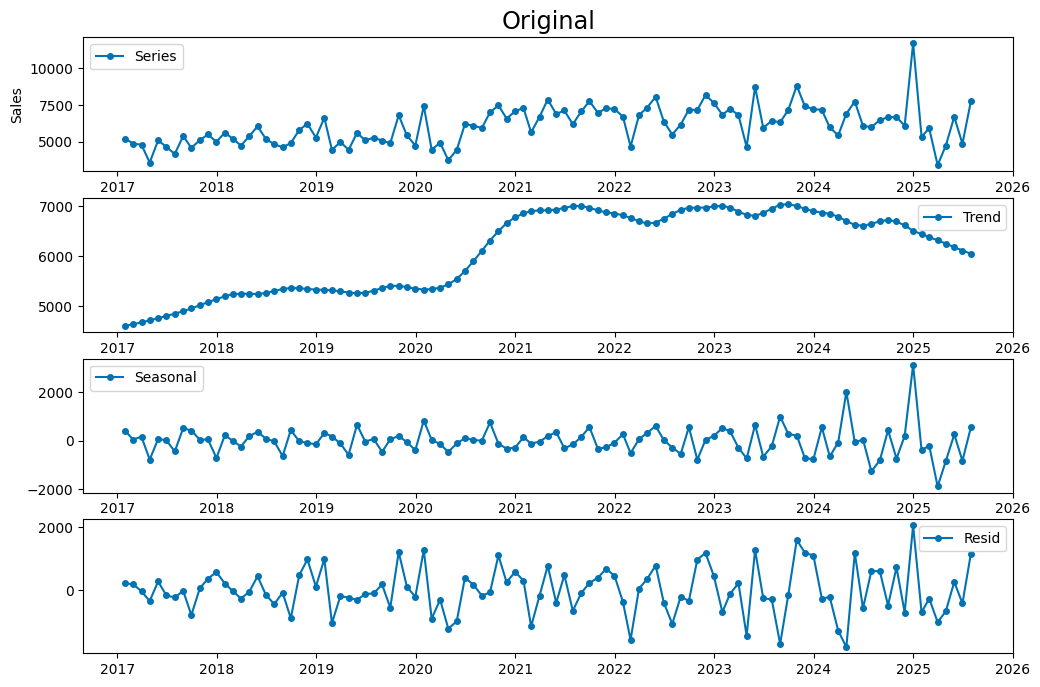

In [8]:
decompose = STLTransformer(sp=8,seasonal=7)
yy = decompose.fit_transform(y)

fig, ax = plt.subplots(4,1,figsize=(12,8))

plot_series(y,labels=['Series'],title='Original',ax=ax[0])
plot_series(decompose.trend_,labels=['Trend'],ax=ax[1])
plot_series(decompose.seasonal_,labels=['Seasonal'],ax=ax[2])
plot_series(decompose.resid_,labels=['Resid'],ax=ax[3])
plt.show()


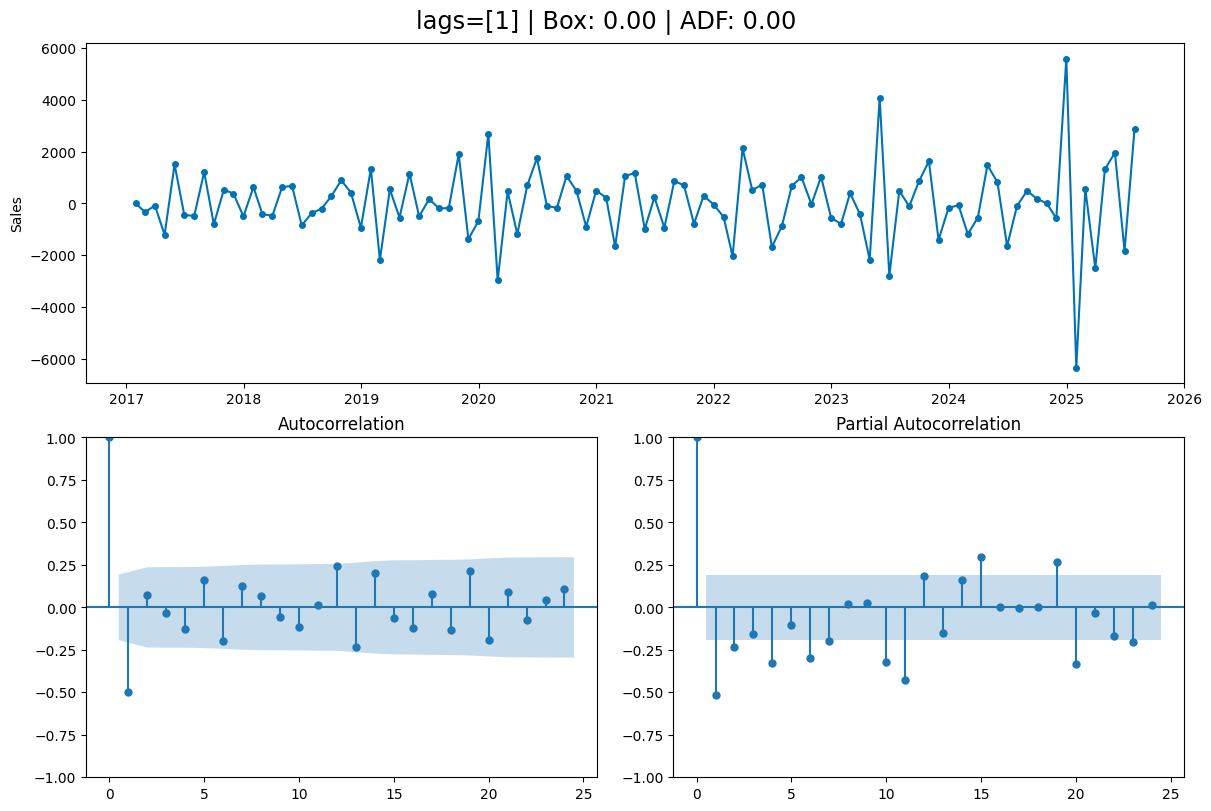

In [9]:
lags = [1]
transf = Differencer(lags=lags)
yy = transf.fit_transform(y)
plot_correlations(yy,pacf_method='ols',suptitle=f"lags={lags} | Box: {box(yy,lags=12)['lb_pvalue'].values[-1]:.2f} | ADF: {adfuller(yy,maxlag=12)[1]:.2f}")
plt.show()

In [ ]:
SeasonalDummiesOneHot(freq='M',drop=False)

In [28]:
x.columns

Index(['CAT mínimo de créditos en pesos a tasa fija',
       'CAT máximo de créditos en pesos a tasa fija',
       'CAT promedio de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT mínimo de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT máximo de créditos en pesos a tasa fija',
       'Tasa de interés promedio de créditos en pesos a tasa fija',
       'Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora',
       'Índice de productividad laboral con base en el personal ocupado total (Índice Base 2018 = 100)',
       'Índice de productividad laboral con base en las horas trabajadas totales (Índice Base 2018 = 100)',
       'Índice de remuneraciones medias reales con base en el personal ocupado total (Índice Base 2018 = 100)',
       'Índice de remuneraciones medias reales con base en las horas trabajadas totales (Índice Base 2018 = 100)',
       'Índice del costo unitario de la mano de obra con base en el personal ocupado total (Ín

In [139]:
x_seas = SeasonalDummiesOneHot(freq='M',drop=False).fit_transform(x)
y_train, y_test, x_train, x_test = temporal_train_test_split(y=y,X=x_seas, test_size=6)
transf = ColumnEnsembleTransformer(
    [
        ("scaler", ss, ['Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora'])
    ],remainder='drop') + \
    Id() * ColumnSelect(columns=['Apr'])
    #Id() * FourierFeatures(sp_list=[12],fourier_terms_list=[10], freq='M')
model = transf ** (StatsModelsARIMA(order=(0,1,1),seasonal_order=(0,0,0,12), trend='n'))
model.fit(y=y_train,X=x_train,fh=y_test.index)
try:
  print(model.summary())
except AttributeError as e:
  try:
    print(model.forecaster_.summary())
  except AttributeError as e:
    print(model.forecaster_.forecaster_.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -805.425
Date:                Thu, 18 Sep 2025   AIC                           1624.851
Time:                        18:36:49   BIC                           1642.801
Sample:                    01-31-2017   HQIC                          1632.107
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
ColumnEnsembleTransformer__Baja California     -2.265e+15    226.007     -1e+13      0.000   -2.27e+15   -2.27e+15
ColumnEnsembleTransform

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


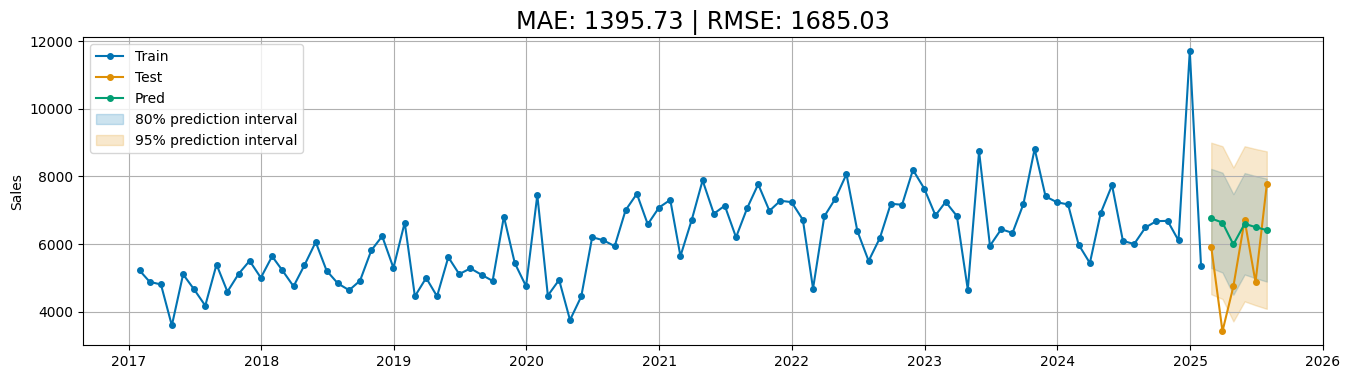

In [140]:
y_pred = model.predict(X=x_test,fh=y_test.index)
y_ci = model.predict_interval(X=x_test,fh=y_test.index,coverage=[0.8,0.95])

fig,ax = plot_series(y_train,y_test,y_pred,labels=['Train','Test','Pred'],title=f'MAE: {mae(y_test,y_pred):.2f} | RMSE: {rmse(y_test,y_pred):.2f}',pred_interval=y_ci)

ax.grid(True)
plt.show()

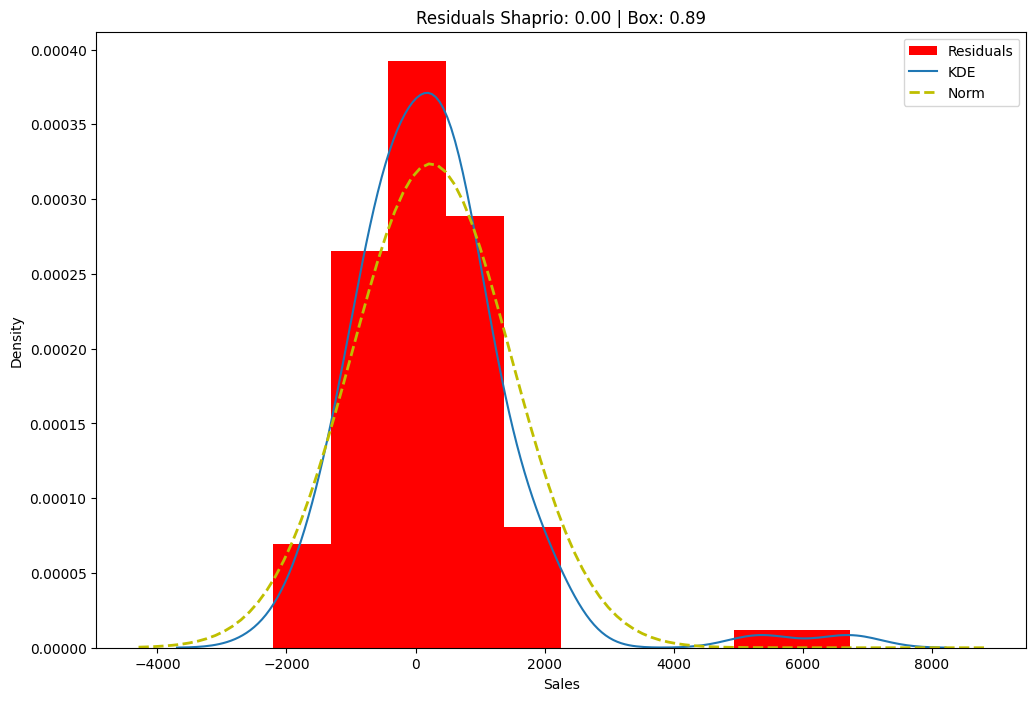

In [141]:
res = y_train - model.predict(X=x_train,fh=y_train.index)
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
resx = np.linspace(xmin, xmax, 100)
p = norm.pdf(resx, mu, std)
ax.plot(resx, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Sales'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

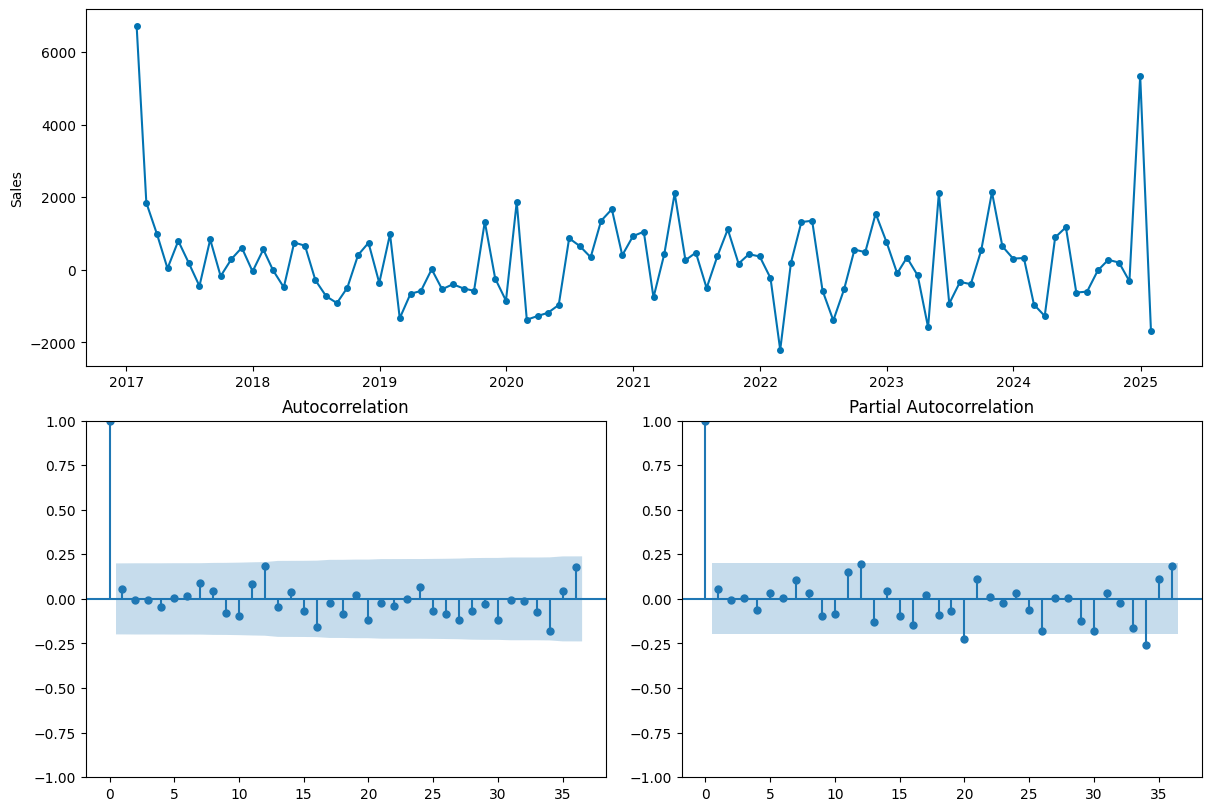

In [142]:
plot_correlations(res,pacf_method='ols',lags=36)

In [143]:
cv=ExpandingWindowSplitter(fh=np.arange(1,7),step_length=6,initial_window=len(df)-6*5)
results = evaluate(model,cv=cv,y=y,X=x,scoring=[mae,rmse],return_data=True)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' ins

/tmp/ipython-input-3098537228.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  test = pd.concat([test,d])
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


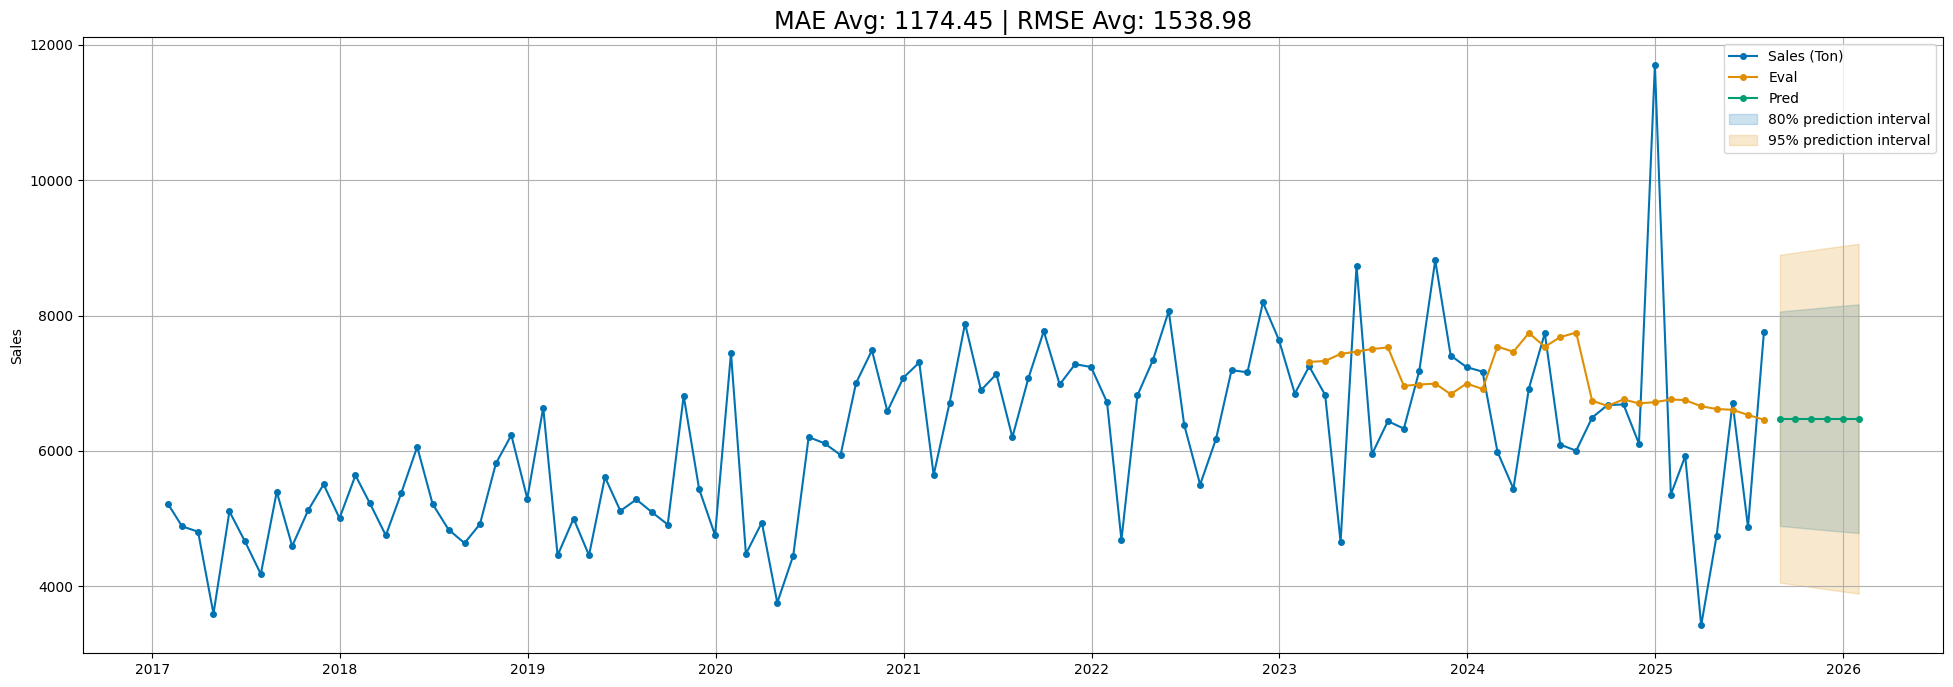

In [144]:
b = ['Sales']
fh = pd.date_range('2025-08',periods=6,freq='ME')
values = np.ones((6,58)) * x.iloc[-1].values
x_pred = pd.DataFrame(values,index=fh,columns=x.columns)
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
test = test.sort_index() # Sort the index
b.append('Eval')
model.fit(y,x,fh=y.index)
y_pred = model.predict(X=x_pred,fh=fh)
y_pred = pd.DataFrame(y_pred,index=fh,columns=['Sales'])
b.append('Pred')
y_ci = model.predict_interval(X=x_pred,fh=fh,coverage=[0.8,0.95])

fig, ax = plt.subplots(figsize=(24,8))
plot_series(y,test,y_pred,labels=['Sales (Ton)','Eval','Pred'],title=f'MAE Avg: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE Avg: {results['test_MeanSquaredError'].mean():.2f}',pred_interval=y_ci,ax=ax)

ax.grid(True)
plt.show()

In [145]:
pd.concat([y_pred,y_ci],axis=1)

,Sales,"(Sales, 0.8, lower)","(Sales, 0.8, upper)","(Sales, 0.95, lower)","(Sales, 0.95, upper)"
2025-08-31,6475.743098,4892.133859,8059.352336,4053.821767,8897.664428
2025-09-30,6475.743098,4870.326615,8081.159580,4020.470466,8931.015730
2025-10-31,6475.743098,4848.811647,8102.674548,3987.566162,8963.920034
2025-11-30,6475.743098,4827.577510,8123.908686,3955.091350,8996.394845
2025-12-31,6475.743098,4806.613484,8144.872712,3923.029640,9028.456556
2026-01-31,6475.743098,4785.909517,8165.576678,3891.365655,9060.120541


In [146]:
x_seas.columns

Index(['CAT mínimo de créditos en pesos a tasa fija',
       'CAT máximo de créditos en pesos a tasa fija',
       'CAT promedio de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT mínimo de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT máximo de créditos en pesos a tasa fija',
       'Tasa de interés promedio de créditos en pesos a tasa fija',
       'Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora',
       'Índice de productividad laboral con base en el personal ocupado total (Índice Base 2018 = 100)',
       'Índice de productividad laboral con base en las horas trabajadas totales (Índice Base 2018 = 100)',
       'Índice de remuneraciones medias reales con base en el personal ocupado total (Índice Base 2018 = 100)',
       'Índice de remuneraciones medias reales con base en las horas trabajadas totales (Índice Base 2018 = 100)',
       'Índice del costo unitario de la mano de obra con base en el personal ocupado total (Ín

In [41]:
x_seas = SeasonalDummiesOneHot(freq='M',drop=False).fit_transform(x)
y_train, y_test, x_train, x_test = temporal_train_test_split(y=y,X=x_seas, test_size=6)
transf = ColumnEnsembleTransformer(
    [
        ("scaler", ss, ['Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora'])
    ],remainder='drop') + \
    Id() * ColumnSelect(columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'])
    #Id() * FourierFeatures(sp_list=[12],fourier_terms_list=[10], freq='M')
model = Prophet(freq='ME',add_country_holidays={"country_name":"MX"})
model.fit(y=y_train,X=x_train)

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/2846nc1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/vki_kayv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33970', 'data', 'file=/tmp/tmparjt9ro3/2846nc1g.json', 'init=/tmp/tmparjt9ro3/vki_kayv.json', 'output', 'file=/tmp/tmparjt9ro3/prophet_model0cv8zb8t/prophet_model-20250919041937.csv', 'met

Prophet(add_country_holidays={'country_name': 'MX'}, freq='ME')

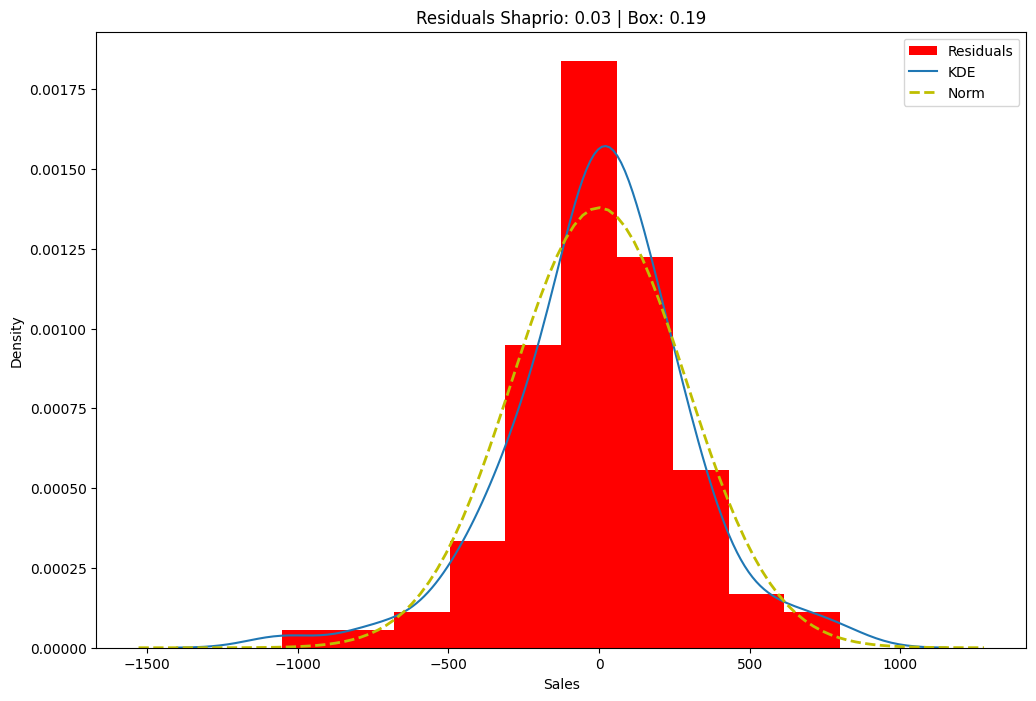

In [42]:
res = y_train - model.predict(X=x_train,fh=y_train.index)
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
resx = np.linspace(xmin, xmax, 100)
p = norm.pdf(resx, mu, std)
ax.plot(resx, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/czgx5ctw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/yxdtbcfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44997', 'data', 'file=/tmp/tmparjt9ro3/czgx5ctw.json', 'init=/tmp/tmparjt9ro3/yxdtbcfr.json', 'output', 'file=/tmp/tmparjt9ro3/prophet_model24ngk3k6/prophet_model-20250919041954.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


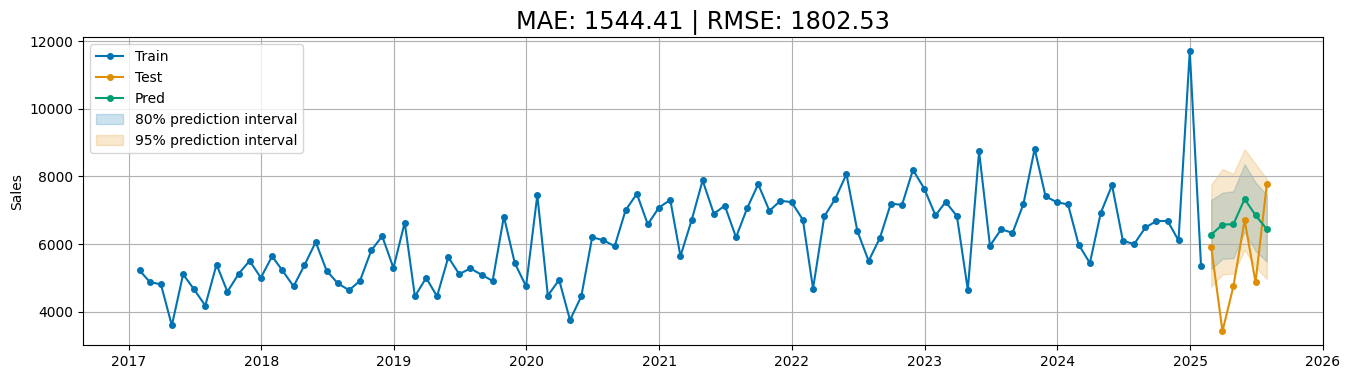

In [43]:
x = df.drop(['Sales','Jalisco'],axis=1)
y_train, y_test, x_train, x_test = temporal_train_test_split(y=y,X=x, test_size=6)
transf = ColumnEnsembleTransformer(
    [
        ("log-saler", ss, ['Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora'])
    ],remainder='drop') #+ \
    #Id() * FourierFeatures(sp_list=[12],fourier_terms_list=[10], freq='M')
model = transf ** (Prophet(freq='ME',add_country_holidays={"country_name":"MX"}))
model.fit(y=y_train,X=x_train)
y_pred = model.predict(X=x_test,fh=y_test.index)
y_ci = model.predict_interval(X=x_test,fh=y_test.index,coverage=[0.8,0.95])

fig,ax = plot_series(y_train,y_test,y_pred,labels=['Train','Test','Pred'],title=f'MAE: {mae(y_test,y_pred):.2f} | RMSE: {rmse(y_test,y_pred):.2f}',pred_interval=y_ci)

ax.grid(True)
plt.show()

In [44]:
cv=ExpandingWindowSplitter(fh=np.arange(1,7),step_length=6,initial_window=len(df)-6*5)
results = evaluate(model,cv=cv,y=y,X=x,scoring=[mae,rmse],return_data=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/fuih39t0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/65avtgpo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55220', 'data', 'file=/tmp/tmparjt9ro3/fuih39t0.json', 'init=/tmp/tmparjt9ro3/65avtgpo.json', 'output', 'file=/tmp/tmparjt9ro3/prophet_modelc4kcmhv0/prophet_model-20250919042004.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages

/tmp/ipython-input-3098537228.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  test = pd.concat([test,d])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/qu_xeyuf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparjt9ro3/n0up_o73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21939', 'data', 'file=/tmp/tmparjt9ro3/qu_xeyuf.json', 'init=/tmp/tmparjt9ro3/n0up_o73.json', 'output', 'file=/tmp/tmparjt9ro3/prophet_model6s5

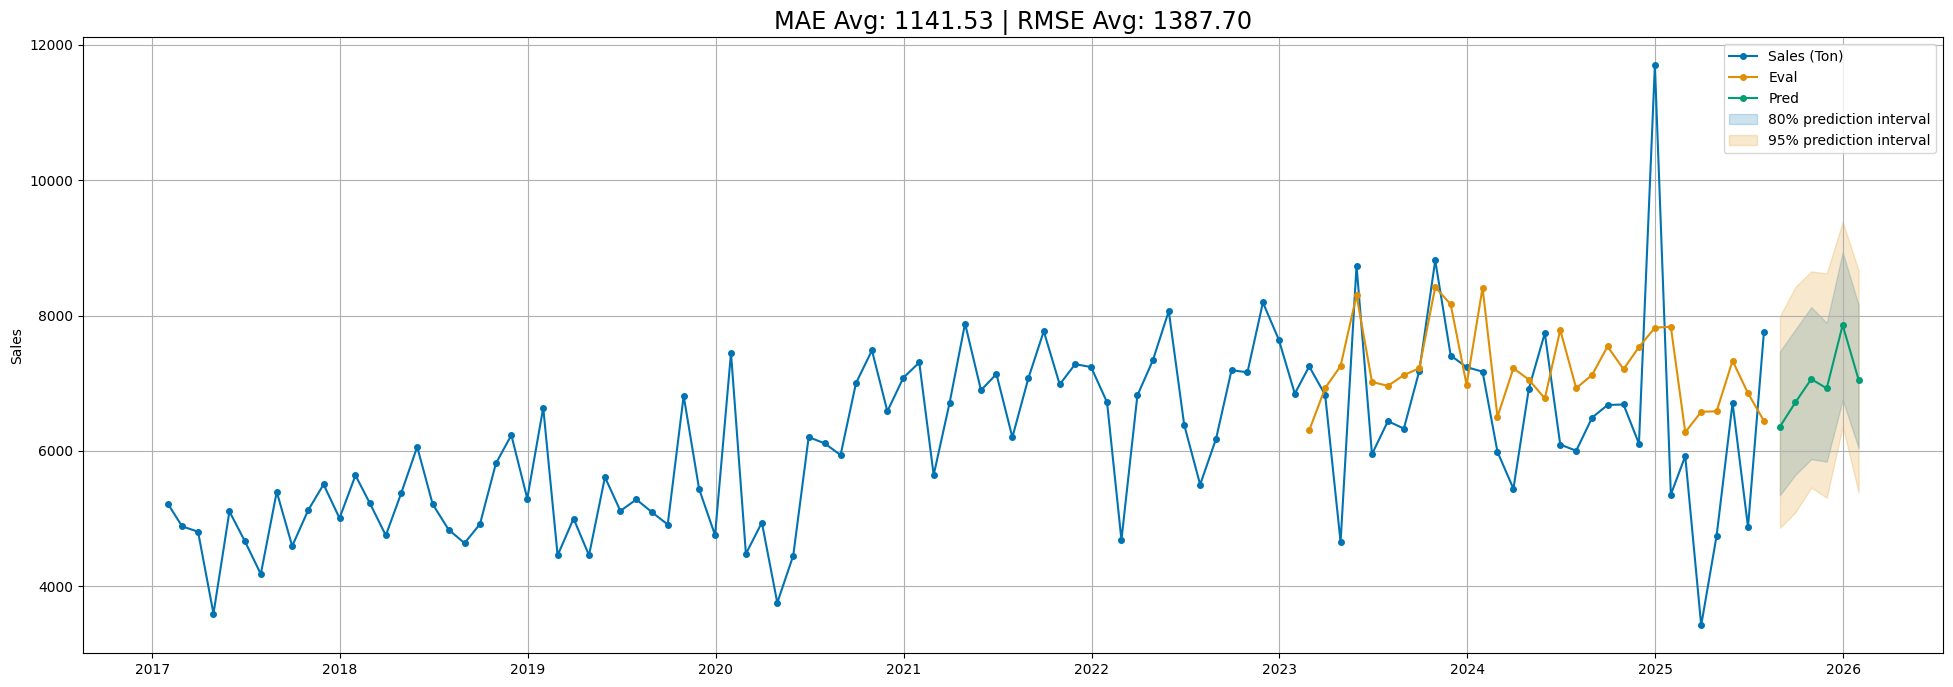

In [45]:
b = ['Sales']
fh = pd.date_range('2025-08',periods=6,freq='ME')
values = np.ones((6,58)) * x.iloc[-1].values
x_pred = pd.DataFrame(values,index=fh,columns=x.columns)
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
test = test.sort_index() # Sort the index
b.append('Eval')
model.fit(y,x,fh=y.index)
y_pred = model.predict(X=x_pred,fh=fh)
y_pred = pd.DataFrame(y_pred,index=fh,columns=['Sales'])
b.append('Pred')
y_ci = model.predict_interval(X=x_pred,fh=fh,coverage=[0.8,0.95])

fig, ax = plt.subplots(figsize=(24,8))
plot_series(y,test,y_pred,labels=['Sales (Ton)','Eval','Pred'],title=f'MAE Avg: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE Avg: {results['test_MeanSquaredError'].mean():.2f}',pred_interval=y_ci,ax=ax)

ax.grid(True)
plt.show()

In [141]:
pd.concat([y_pred,y_ci],axis=1)

,Sales,"(Sales, 0.8, lower)","(Sales, 0.8, upper)","(Sales, 0.95, lower)","(Sales, 0.95, upper)"
2025-08-31,6356.522919,5103.705565,7550.659428,4644.080506,8127.175071
2025-09-30,6734.159071,5433.628572,7907.637602,4692.682720,8530.221192
2025-10-31,7305.825882,6088.018954,8481.761850,5615.608220,9168.488287
2025-11-30,7064.352636,5822.596987,8323.335051,5320.212114,8887.111390
2025-12-31,7448.012651,6236.921595,8645.492059,5573.483024,9401.669654
2026-01-31,7142.128681,5827.545752,8368.363463,5413.902275,9002.877330


In [180]:
x_seas.columns

Index(['CAT mínimo de créditos en pesos a tasa fija',
       'CAT máximo de créditos en pesos a tasa fija',
       'CAT promedio de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT mínimo de créditos en pesos a tasa fija',
       'Tasa de interés asociada al CAT máximo de créditos en pesos a tasa fija',
       'Tasa de interés promedio de créditos en pesos a tasa fija',
       'Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora',
       'Índice de productividad laboral con base en el personal ocupado total (Índice Base 2018 = 100)',
       'Índice de productividad laboral con base en las horas trabajadas totales (Índice Base 2018 = 100)',
       'Índice de remuneraciones medias reales con base en el personal ocupado total (Índice Base 2018 = 100)',
       'Índice de remuneraciones medias reales con base en las horas trabajadas totales (Índice Base 2018 = 100)',
       'Índice del costo unitario de la mano de obra con base en el personal ocupado total (Ín

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0

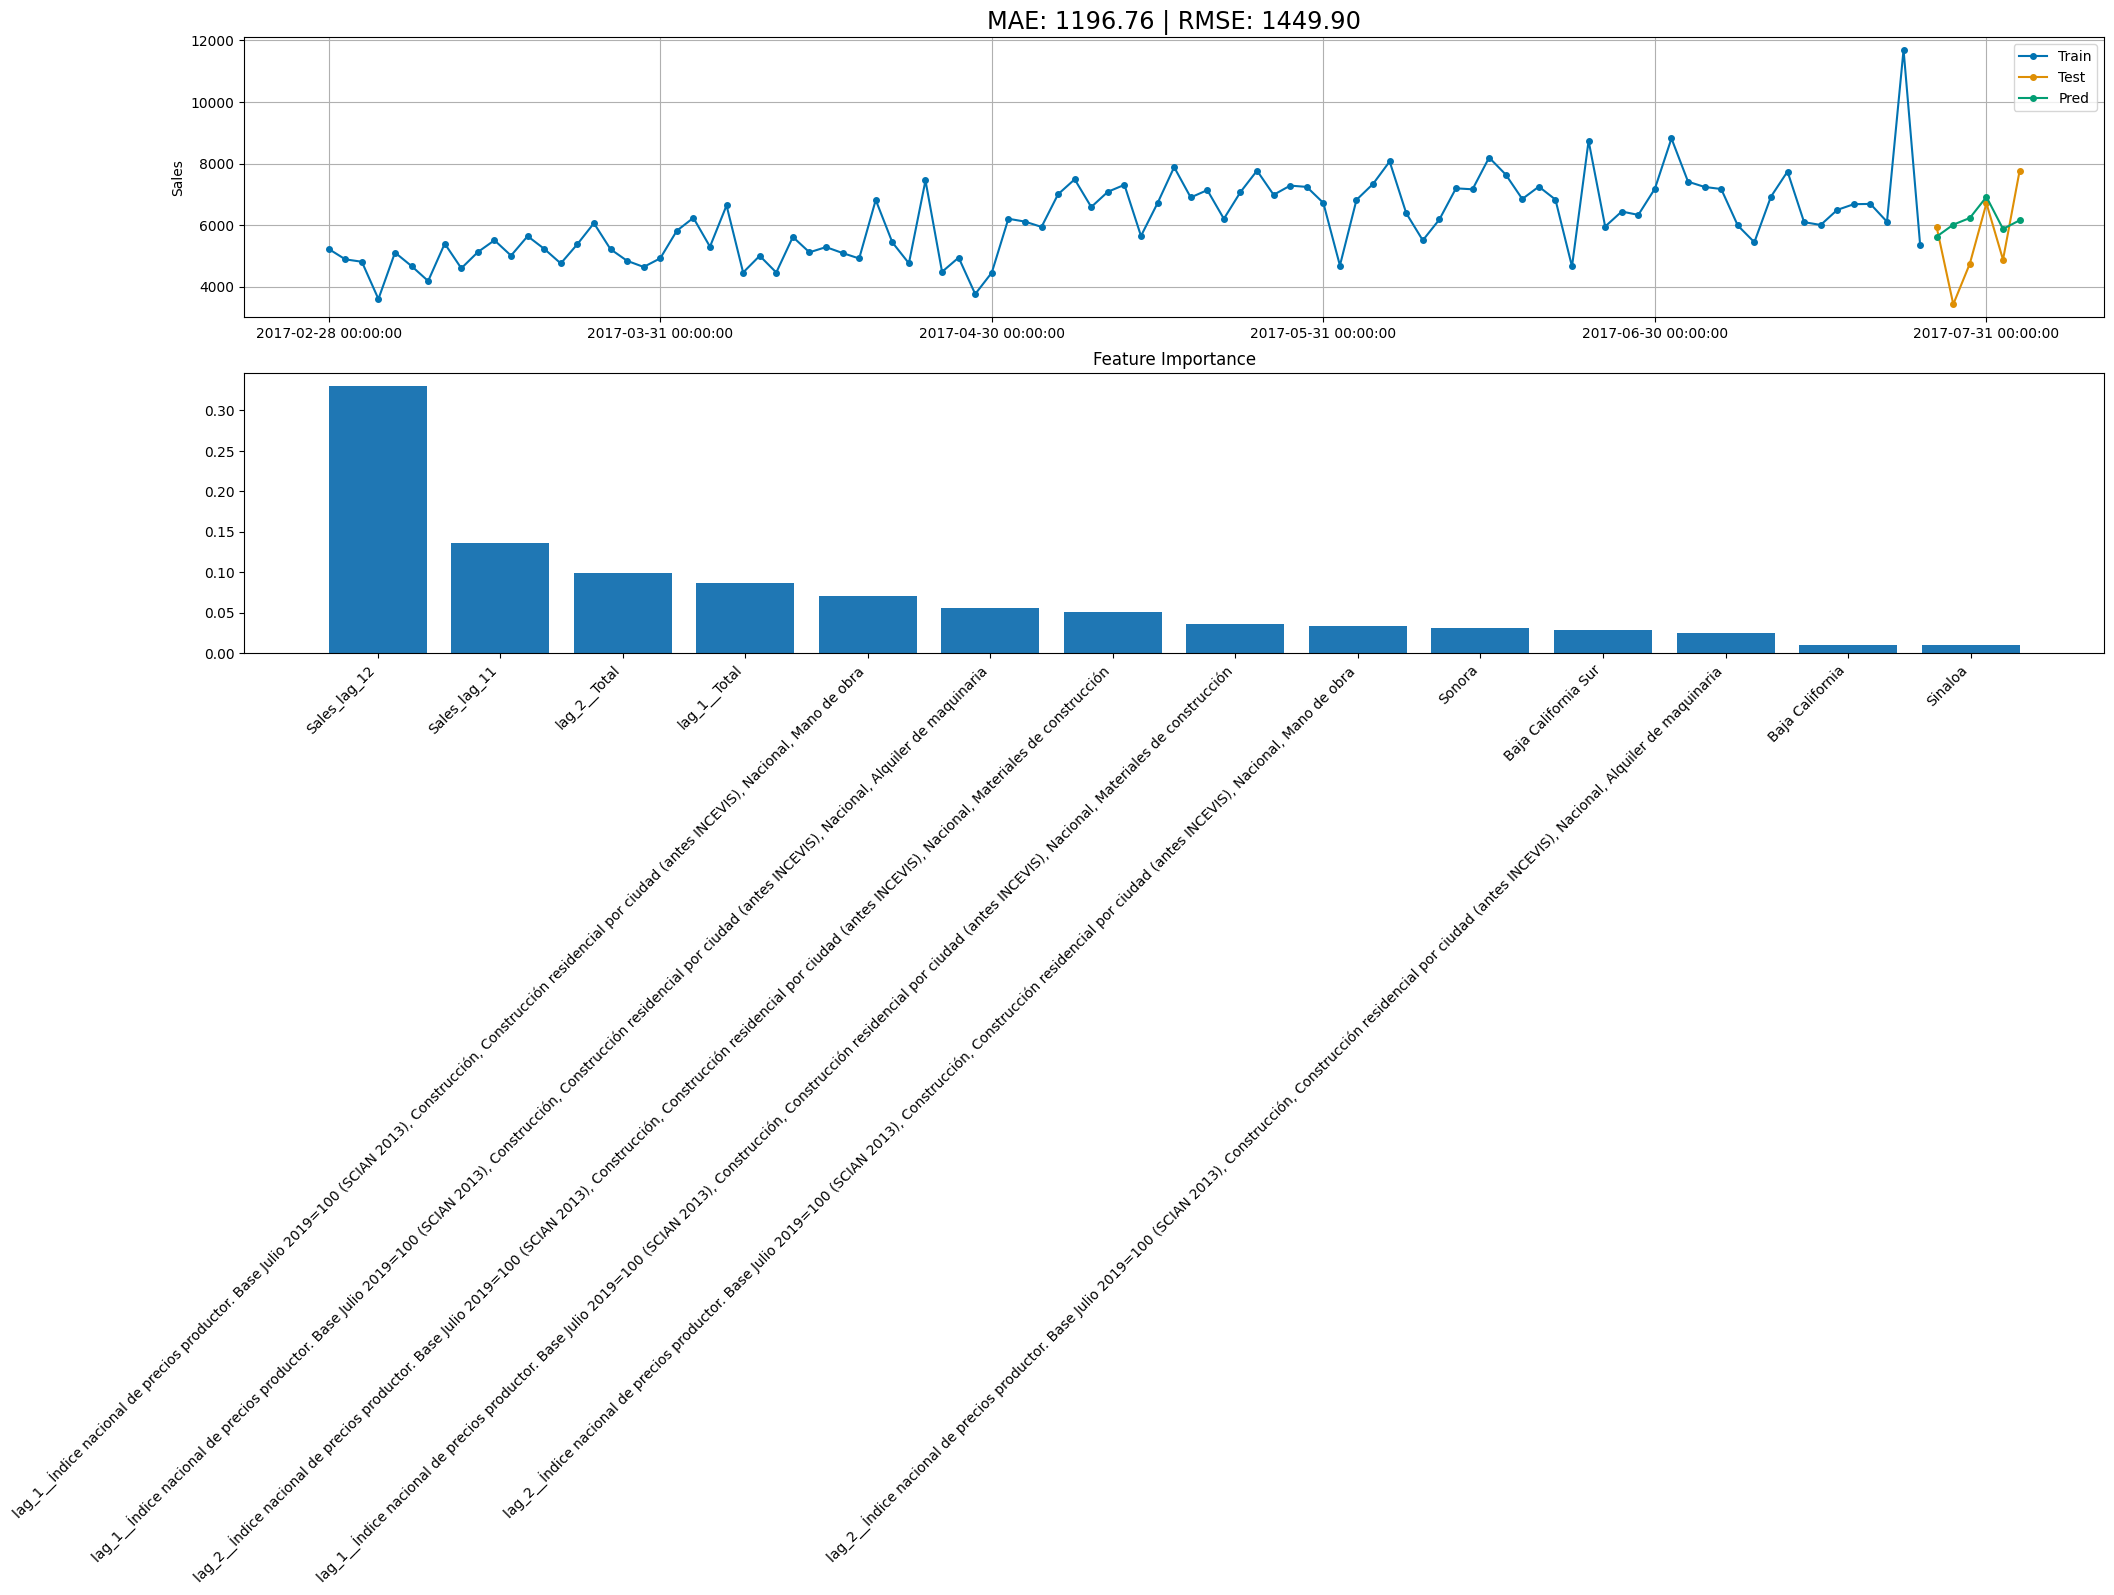

In [8]:
x_seas = SeasonalDummiesOneHot(freq='M',drop=False).fit_transform(x)
y_train, y_test, x_train, x_test = temporal_train_test_split(y=y.reset_index(drop=True),X=x_seas.reset_index(drop=True), test_size=6)
transf = ColumnEnsembleTransformer(
    [
        ("scaler", ss * Differencer(lags=[1,2],na_handling='fill_zero') * Imputer('mean'), ['Baja California', 'Baja California Sur', 'Sinaloa', 'Sonora']),
        ("lags",Lag(lags=[1,2],index_out='original') * Imputer('nearest'),['Total','Índice nacional de precios productor. Base Julio 2019=100 (SCIAN 2013), Construcción, Construcción residencial por ciudad (antes INCEVIS), Nacional, Materiales de construcción',
       'Índice nacional de precios productor. Base Julio 2019=100 (SCIAN 2013), Construcción, Construcción residencial por ciudad (antes INCEVIS), Nacional, Alquiler de maquinaria',
       'Índice nacional de precios productor. Base Julio 2019=100 (SCIAN 2013), Construcción, Construcción residencial por ciudad (antes INCEVIS), Nacional, Mano de obra',])
    ],remainder='drop') #+ \
    # ColumnSelect(columns=['Apr', 'Dec'])
    # Id() * FourierFeatures(sp_list=[12],fourier_terms_list=[10], freq='M')

ws = WindowSummarizer(
    lag_feature={
      "lag": [11,12]
    },
    n_jobs=-1,

)

model = transf ** (make_reduction(estimator=RandomForestRegressor(max_depth=4,n_estimators=200,n_jobs=-1,random_state=42),strategy='recursive',pooling='global',window_length=None,transformers=[ws]))
model.fit(y=y_train,X=x_train,fh=np.arange(1,7))
y_pred = model.predict(X=x_test)
try:
  importances = pd.DataFrame(model.forecaster_.forecaster_.estimator_.feature_importances_,index=model.forecaster_.forecaster_.estimator_.feature_names_in_,columns=['Importance']).sort_values(by='Importance',ascending=False)

except AttributeError:
  importances = pd.DataFrame(model.forecaster_.estimator_.feature_importances_,index=model.forecaster_.estimator_.feature_names_in_,columns=['Importance']).sort_values(by='Importance',ascending=False)

fig,ax = plt.subplots(2,1,figsize=(24,8))

plot_series(y_train,y_test,y_pred,labels=['Train','Test','Pred'],title=f'MAE: {mae(y_test,y_pred):.2f} | RMSE: {rmse(y_test,y_pred):.2f}',ax=ax[0])
ax[1].bar(importances.index,importances['Importance'])
ax[1].set_title('Feature Importance')
ax[0].set_xticklabels(y.index)
ax[0].grid(True)
ax[1].set_xticklabels(importances.index, rotation=45, ha='right')
plt.show()

In [9]:
cv=ExpandingWindowSplitter(fh=np.arange(1,7),step_length=6,initial_window=len(df)-6*5)
results = evaluate(model,cv=cv,y=y.reset_index(drop=True),X=x.reset_index(drop=True),scoring=[mae,rmse],return_data=True,error_score='raise')

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0

/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/usr/local/lib/python3.12/dist-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/tmp/ipython-input-1822994996.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(y.index)


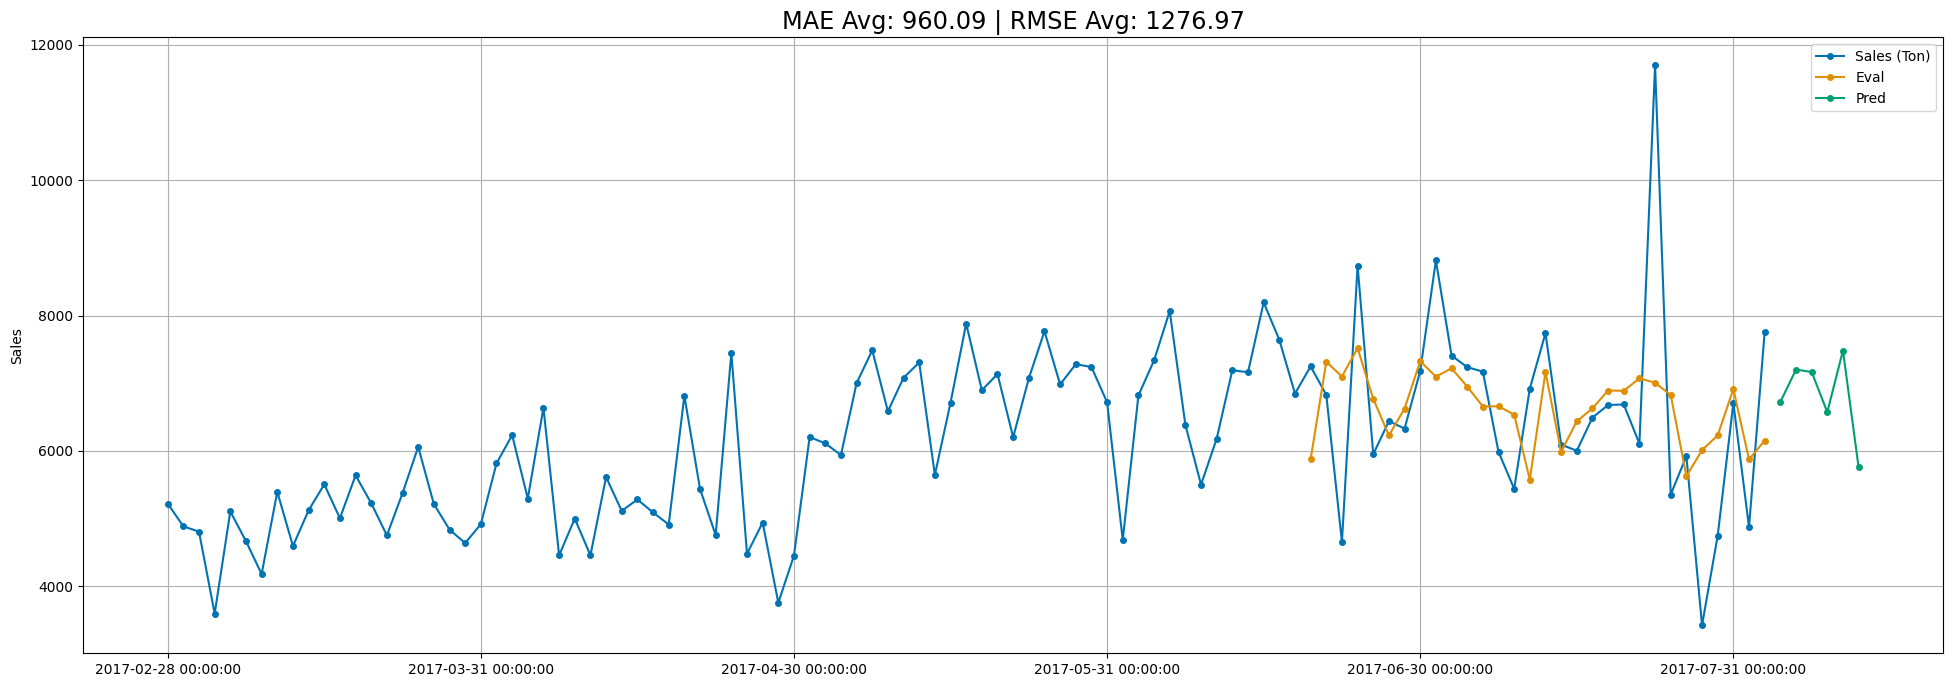

In [11]:
b = ['Sales']
fh = pd.date_range('2025-08',periods=6,freq='ME')
values = np.ones((6,58)) * x.iloc[-1].values
x_pred = pd.DataFrame(values,index=fh,columns=x.columns)
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
test = test.sort_index() # Sort the index
b.append('Eval')
model.fit(y.reset_index(drop=True),x.reset_index(drop=True),fh=np.arange(1,7))
y_pred = model.predict(X=x_pred.reset_index(drop=True),fh=np.arange(1,7))
b.append('Pred')
# y_ci = model.predict_interval(X=x_pred,fh=fh,coverage=[0.8,0.95])

fig,ax = plt.subplots(figsize=(24,8))
plot_series(y.reset_index(drop=True),test,y_pred,labels=['Sales (Ton)','Eval','Pred'],title=f'MAE Avg: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE Avg: {results['test_MeanSquaredError'].mean():.2f}',ax=ax)

ax.set_xticklabels(y.index)
ax.grid(True)
plt.show()

ax.grid(True)
plt.show()

In [13]:
y_pred

,Sales
103,6722.784017
104,7201.599192
105,7166.180127
106,6573.037292
107,7483.208048
108,5757.039037
